# Notas de la tutoría

https://docs.google.com/document/d/1OFimhBpQRmyhBzsIPMzMCz5L3U5bnUaSXxvbL6H2dS0/edit?usp=sharing

# Importar librerías

In [ ]:
from google.colab import drive
drivedir = r'/content/drive'
drive.mount(drivedir)

import os
import numpy as np
import pandas as pd
import datetime as dt
import gc
!pip install category_encoders
import category_encoders as ce

# Visualización de datos
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


# Configuración
pd.pandas.set_option('display.max_columns', None)
rootdir = os.path.join(drivedir, '/content/drive/MyDrive/Colab Notebooks/Store Sales')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 853.0 kB/s eta 0:00:00


# Cargar datos

In [ ]:
data = pd.read_csv(os.path.join(rootdir, 'train.csv'))
test = pd.read_csv(os.path.join(rootdir, 'test.csv'))
transactions=pd.read_csv(os.path.join(rootdir, 'transactions.csv'))
stores=pd.read_csv(os.path.join(rootdir, 'stores.csv'))
oil=pd.read_csv(os.path.join(rootdir, 'oil.csv'))
holidays_events=pd.read_csv(os.path.join(rootdir, 'holidays_events.csv'))

In [ ]:
#Leemos las primeras filas de cada dataset
data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


The training data, comprising time series of features **store_nbr**, family,
and **onpromotion** as well as the target **sales**.

**store_nbr** identifies the store at which the products are sold.

**family** identifies the type of product sold.

**sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

**onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

In [ ]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


The test data, having the same features as the training data. You will predict the target **sales** for the dates in this file.

The dates in the test data are for the 15 days after the last date in the training data.

In [ ]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Store metadata, including **city**, **state**, **type**, and **cluster**.

**cluster** is a grouping of similar stores.

In [ ]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [ ]:
holidays_events.head(100)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
95,2014-03-04,Holiday,National,Ecuador,Carnaval,False
96,2014-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
97,2014-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
98,2014-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False


In [ ]:
holidays_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


Holidays and Events, with metadata

NOTE: Pay special attention to the **transferred** column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

**Additional notes**

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# Procesado de datos

## Comprobar valores nulos

In [ ]:
data_processed = data.copy()
test_processed = test.copy()
transaction_processed = transactions.copy()
stores_processed = stores.copy()
oil_processed = oil.copy()
holidays_events_processed = holidays_events.copy()

# Preparamos los datos para la interpolación y la combinación que vendrán después
# if 'id' in data_processed.columns:
  # data_processed.set_index('id', inplace=True)

data_processed['date'] = data_processed['date'].astype('datetime64[ns]')
test_processed['date'] = test_processed['date'].astype('datetime64[ns]')

# if 'date' in oil_processed.columns:
#   oil_processed.set_index('date', inplace=True)
# oil_processed.index = pd.to_datetime(oil_processed.index)
oil_processed['date'] = pd.to_datetime(oil_processed['date'])

# if 'date' in holidays_events_processed.columns:
#   holidays_events_processed.set_index('date', inplace=True)
# holidays_events_processed.index = pd.to_datetime(holidays_events_processed.index)
holidays_events_processed['date'] = pd.to_datetime(holidays_events_processed['date'])

# if 'date' in transaction_processed.columns:
#   transaction_processed.set_index('date', inplace=True)
# transaction_processed.index = pd.to_datetime(transaction_processed.index)
transaction_processed['date'] = pd.to_datetime(transaction_processed['date'])

oil_processed

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


## Rellenar valores nulos

Solo se encuentran valores nulos en el dataset del precio del crudo

In [ ]:
# Hay valores nulos y también faltan filas para los fines de semana, que también las vamos a rellenar porque el fin de semana las tiendas tienen datos de ventas
# Primero añadimos las filas que faltan

if 'date' in oil_processed.columns:
  oil_processed.set_index('date', inplace=True)
oil_processed.index = pd.to_datetime(oil_processed.index)


new_date_range = pd.date_range(start=oil_processed.index[0], end=oil_processed.index[-1], freq="D")
oil_processed = oil_processed.reindex(new_date_range)
oil_processed.index.name = 'date'


# Interpolamos para rellenar los valores nulos
# Usamos el método "time" en la interpolación ya que solo hay datos de lunes a viernes, así que no son continuos del todo
# Usamos limit_direction="both" para que también interpole el primer valor de la serie, que está vacío

oil_processed.interpolate(method='time', limit_direction='both', inplace=True)
oil_processed

,dcoilwtico
date,
2013-01-01,93.140000
2013-01-02,93.140000
2013-01-03,92.970000
2013-01-04,93.120000
2013-01-05,93.146667
...,...
2017-08-27,46.816667
2017-08-28,46.400000
2017-08-29,46.460000


## Eliminamos datos que no aportan

In [ ]:
# Quitamos datos de ventas de algunas tiendas que abrieron más tarde del inicio de la serie temporal

print(data_processed.shape)
data_processed = data_processed[~((data_processed.store_nbr == 52) & (data_processed.date < "2017-04-20"))]
data_processed = data_processed[~((data_processed.store_nbr == 22) & (data_processed.date < "2015-10-09"))]
data_processed = data_processed[~((data_processed.store_nbr == 42) & (data_processed.date < "2015-08-21"))]
data_processed = data_processed[~((data_processed.store_nbr == 21) & (data_processed.date < "2015-07-24"))]
data_processed = data_processed[~((data_processed.store_nbr == 29) & (data_processed.date < "2015-03-20"))]
data_processed = data_processed[~((data_processed.store_nbr == 20) & (data_processed.date < "2015-02-13"))]
data_processed = data_processed[~((data_processed.store_nbr == 53) & (data_processed.date < "2014-05-29"))]
data_processed = data_processed[~((data_processed.store_nbr == 36) & (data_processed.date < "2013-05-09"))]
data_processed.shape

(3000888, 6)


(2780316, 6)

In [ ]:
# Quitamos las filas de ventas de productos que no se han vendido nunca en algunas tiendas. Guardamos este dataframe para combinarlo con la predicción final
# no_vendidos = data_processed.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
# no_vendidos = no_vendidos[no_vendidos.sales == 0]

# outer_join = data_processed.merge(no_vendidos[no_vendidos.sales == 0].drop('sales', axis=1), how='outer', indicator=True)
# data_processed = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
# del outer_join
# gc.collect()

# no_vendidos

In [ ]:
# prediccion_no_vendidos = []
# for i in range(0,len(no_vendidos)):
#     prediccion_no_vendidos.append(
#         pd.DataFrame({
#             "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
#             "store_nbr":no_vendidos.store_nbr.iloc[i],
#             "family":no_vendidos.family.iloc[i],
#             "sales":0
#         })
#     )
# prediccion_no_vendidos = pd.concat(prediccion_no_vendidos)
# # del c
# # gc.collÇect()
# prediccion_no_vendidos.to_csv( os.path.join( rootdir, 'forecast_no_vendidos.csv'), index=False, encoding='utf-8' )
# prediccion_no_vendidos

,date,store_nbr,family,sales
0,2017-08-16,1,BABY CARE,0
1,2017-08-17,1,BABY CARE,0
2,2017-08-18,1,BABY CARE,0
3,2017-08-19,1,BABY CARE,0
4,2017-08-20,1,BABY CARE,0
...,...,...,...,...
11,2017-08-27,54,LAWN AND GARDEN,0
12,2017-08-28,54,LAWN AND GARDEN,0
13,2017-08-29,54,LAWN AND GARDEN,0
14,2017-08-30,54,LAWN AND GARDEN,0


## Nueva feature: día mes y año

Estudiamos el comportamiento del número de transacciones en diferentes periodos de tiempo para ver si conviene extraer alguna característica de la fecha a una columna independiente.

- Mes
- Día
- Día de la semana

In [ ]:
# Media de transacciones por meses
temp = transaction_processed.copy()
temp["year"] = temp.date.dt.year
temp["month"] = temp.date.dt.month
temp = temp.groupby(["year", "month"]).transactions.mean().reset_index()
px.line(temp, x="month", y="transactions" , color = "year", title = "Transactions")

In [ ]:
# Media de transacciones por día del mes (puede tener relevancia porque se cobra el día 15 y el último día de mes)
temp = transaction_processed.copy()
temp["year"] = temp.date.dt.year
temp["day"] = temp.date.dt.day
temp = temp.groupby(["year", "day"]).transactions.mean().reset_index()
px.line(temp, x="day", y="transactions" , color = "year", title = "Transactions")

In [ ]:
temp = transaction_processed.copy()
temp["year"] = temp.date.dt.year
temp["dayofweek"] = temp.date.dt.dayofweek+1
temp = temp.groupby(["year", "dayofweek"]).transactions.mean().reset_index()
px.line(temp, x="dayofweek", y="transactions" , color = "year", title = "Transactions")

In [ ]:
# Metemos el mes como dato de entrada porque tendrá relevancia en las ventas (por ejemplo en diciembre aumentan por Navidad)
data_processed['month'] = pd.DatetimeIndex(data_processed['date']).month

# Metemos el día del mes como dato de entrada porque tendrá relevancia (se cobra el día 15, donde se ve un ligero repunte, y el último día de mes donde es más evidente)
data_processed['day'] = pd.DatetimeIndex(data_processed['date']).day

# Metemos el día de la semana como dato de entrada porque tendrá relevancia (más transacciones en fin de semana)
data_processed['day_of_week'] = pd.DatetimeIndex(data_processed['date']).day_of_week

In [ ]:
data_processed.sample(100)

,id,date,store_nbr,family,sales,onpromotion,month,day,day_of_week
129956,129956,2013-03-14,6,BEAUTY,1.000,0,3,14,3
1742549,1742549,2015-09-07,51,HOME APPLIANCES,0.000,0,9,7,0
1352521,1352521,2015-01-31,9,HOME AND KITCHEN II,23.000,0,1,31,5
1940706,1940706,2015-12-29,12,DELI,237.000,0,12,29,1
1667429,1667429,2015-07-27,44,BREAD/BAKERY,1088.555,2,7,27,0
...,...,...,...,...,...,...,...,...,...
1638290,1638290,2015-07-11,27,BREAD/BAKERY,627.833,0,7,11,5
2934498,2934498,2017-07-09,46,CELEBRATION,17.000,0,7,9,6
2137141,2137141,2016-04-17,23,POULTRY,398.283,1,4,17,6
1652913,1652913,2015-07-19,37,DELI,174.870,1,7,19,6


In [ ]:
# Metemos el mes como dato de entrada en test para que tenga las mismas columnas
test_processed['month'] = pd.DatetimeIndex(test_processed['date']).month

# Metemos el día del mes como dato de entrada en test para que tenga las mismas columnas
test_processed['day'] = pd.DatetimeIndex(test_processed['date']).day

# Metemos el día de la semana como dato de entrada en test para que tenga las mismas columnas
test_processed['day_of_week'] = pd.DatetimeIndex(test_processed['date']).day_of_week

In [ ]:
test_processed.sample(10)

,id,date,store_nbr,family,onpromotion,month,day,day_of_week
13007,3013895,2017-08-23,24,BREAD/BAKERY,15,8,23,2
2672,3003560,2017-08-17,33,SEAFOOD,0,8,17,3
22160,3023048,2017-08-28,30,HOME APPLIANCES,0,8,28,0
15494,3016382,2017-08-24,43,HOME APPLIANCES,0,8,24,3
9655,3010543,2017-08-21,3,LADIESWEAR,0,8,21,0
20232,3021120,2017-08-27,27,BEVERAGES,37,8,27,6
24282,3025170,2017-08-29,4,PLAYERS AND ELECTRONICS,0,8,29,1
2114,3003002,2017-08-17,19,BEAUTY,1,8,17,3
10126,3011014,2017-08-21,42,POULTRY,0,8,21,0
4446,3005334,2017-08-18,33,MEATS,0,8,18,4


## Nueva feature: Media móvil

In [ ]:
# Añadimos la media móvil del último mes como nueva feature
# Primero, reordenar el dataset para tener todas las series temporales seguidas.
a = data_processed.sort_values(["store_nbr", "family", "date"])
b = test_processed.sort_values(["store_nbr", "family", "date"])
b["sales"] = 0
c = pd.concat([a,b])

# Bucle para probar con varios valores. Nos quedamos finalmente con los 30 días para calcular la media por tener la mayor correlación con ventas (por poco)
for i in [30]:
    # shift(16) quiere decir que nos saltamos 16 días hacia atrás para calcular la media móvil, porque tenemos que predecir 15 días
    # así podemos añadir esta feature al dataset de test también
    c["sales_media_movil_"+str(i)+"_dias_lag16"] = c.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(16).values

a = c[(c.date <= "2017-08-15")]
b = c[(c.date > "2017-08-15")]
b = b.drop(["sales"], axis=1)
a

# print("Correlación media móvil y ventas")
# a[["sales"]+a.columns[a.columns.str.startswith("sales_media_movil")].tolist()].corr()
data_processed = a.sort_values(["id"])
test_processed = b.sort_values(["id"])

In [ ]:
print(data_processed.columns)
print(test_processed.columns)

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'month',
       'day', 'day_of_week', 'sales_media_movil_30_dias_lag16'],
      dtype='object')
Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'month', 'day',
       'day_of_week', 'sales_media_movil_30_dias_lag16'],
      dtype='object')


In [ ]:
test_processed

,id,date,store_nbr,family,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16
0,3000888,2017-08-16,1,AUTOMOTIVE,0,8,16,2,2.500000
1,3000889,2017-08-16,1,BABY CARE,0,8,16,2,10.133333
2,3000890,2017-08-16,1,BEAUTY,2,8,16,2,8.766667
3,3000891,2017-08-16,1,BEVERAGES,20,8,16,2,1.033333
4,3000892,2017-08-16,1,BOOKS,0,8,16,2,4.633333
...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,8,31,3,237.833333
28508,3029396,2017-08-31,9,PREPARED FOODS,0,8,31,3,249.533333
28509,3029397,2017-08-31,9,PRODUCE,1,8,31,3,173.266667
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,8,31,3,NaN


In [ ]:
# Comprobamos una de las medias a manija a ver si ha salido todo bien
a[ (a['date'] > '2017-07-15') & (a['date'] < '2017-08-15') & ( a['store_nbr'] == 54 ) & ( a['family'] == 'SEAFOOD') ]

,id,date,store_nbr,family,sales,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16
2947295,2947295,2017-07-16,54,SEAFOOD,5.0,1,7,16,6,0.000000
2949077,2949077,2017-07-17,54,SEAFOOD,3.0,1,7,17,0,0.000000
2950859,2950859,2017-07-18,54,SEAFOOD,6.0,1,7,18,1,0.000000
2952641,2952641,2017-07-19,54,SEAFOOD,0.0,0,7,19,2,0.000000
2954423,2954423,2017-07-20,54,SEAFOOD,3.0,1,7,20,3,0.000000
2956205,2956205,2017-07-21,54,SEAFOOD,0.0,0,7,21,4,0.000000
2957987,2957987,2017-07-22,54,SEAFOOD,3.0,2,7,22,5,0.000000
2959769,2959769,2017-07-23,54,SEAFOOD,5.0,1,7,23,6,0.000000
2961551,2961551,2017-07-24,54,SEAFOOD,1.0,1,7,24,0,0.000000
2963333,2963333,2017-07-25,54,SEAFOOD,7.0,0,7,25,1,0.000000


In [ ]:
#Determinar porcentaje de valores nulos
na_data = data.columns[data.isnull().any()]

print(f"{len(na_data)} columnas de un total de {len(data)} contienen datos nulos en: data")
print("\n")
print("Porcentaje de valores nulos por variable:")
print(data[na_data].isnull().mean()*100)

0 columnas de un total de 3000888 contienen datos nulos en: data


Porcentaje de valores nulos por variable:
Series([], dtype: float64)


In [ ]:
na_transactions = transactions.columns[transactions.isnull().any()]

print(f"{len(na_transactions)} columnas de un total de {len(transactions)} contienen datos nulos en: data")
print("\n")
print("Porcentaje de valores nulos por variable:")
print(transactions[na_transactions].isnull().mean()*100)

0 columnas de un total de 83488 contienen datos nulos en: data


Porcentaje de valores nulos por variable:
Series([], dtype: float64)


In [ ]:
na_stores = stores.columns[stores.isnull().any()]

print(f"{len(na_stores)} columnas de un total de {len(stores)} contienen datos nulos en: data")
print("\n")
print("Porcentaje de valores nulos por variable:")
print(stores[na_stores].isnull().mean()*100)

0 columnas de un total de 54 contienen datos nulos en: data


Porcentaje de valores nulos por variable:
Series([], dtype: float64)


In [ ]:
na_oil = oil.columns[oil.isnull().any()]

print(f"{len(na_oil)} columnas de un total de {len(oil)} contienen datos nulos en: data")
print("\n")
print("Porcentaje de valores nulos por variable:")
print(oil[na_oil].isnull().mean()*100)
print("Cantidad de valores nulos por variable:")
print(oil[na_oil].isnull().sum())

1 columnas de un total de 1218 contienen datos nulos en: data


Porcentaje de valores nulos por variable:
dcoilwtico    3.530378
dtype: float64
Cantidad de valores nulos por variable:
dcoilwtico    43
dtype: int64


In [ ]:
na_holidays_events = holidays_events.columns[holidays_events.isnull().any()]

print(f"{len(na_holidays_events)} columnas de un total de {len(holidays_events)} contienen datos nulos en: data")
print("\n")
print("Porcentaje de valores nulos por variable:")
print(oil[na_holidays_events].isnull().mean()*100)

0 columnas de un total de 350 contienen datos nulos en: data


Porcentaje de valores nulos por variable:
Series([], dtype: float64)


# **Análisis de variables**



## Precio petróleo vs ventas

In [ ]:
# Comprobar relación del precio del petróleo con las ventas y las transacciones
temp = data_processed[['date', 'sales']].copy()
temp = temp.groupby(["date"]).sales.sum().reset_index()
temp = pd.merge(temp, oil_processed, on="date", how="left")

# Normalizar para poder comparar
columns = ['sales', 'dcoilwtico']
for c in columns:
    temp[c] = (temp[c] - temp[c].min()) / (temp[c].max() - temp[c].min())

# temp
fig = px.line(temp, x="date", y="sales" , title = "Sales")
fig.add_scatter(x=temp["date"], y=temp["dcoilwtico"])

fig

## Analizar tendencias por familias
Por si hay productos que ya no se venden en ninguna tienda

Añadimos el precio del crudo también a las gráficas para comprobar si puede afectar algo por familia

Añadimos también una marca para ver si el terremoto afecta a unos productos más que a otros

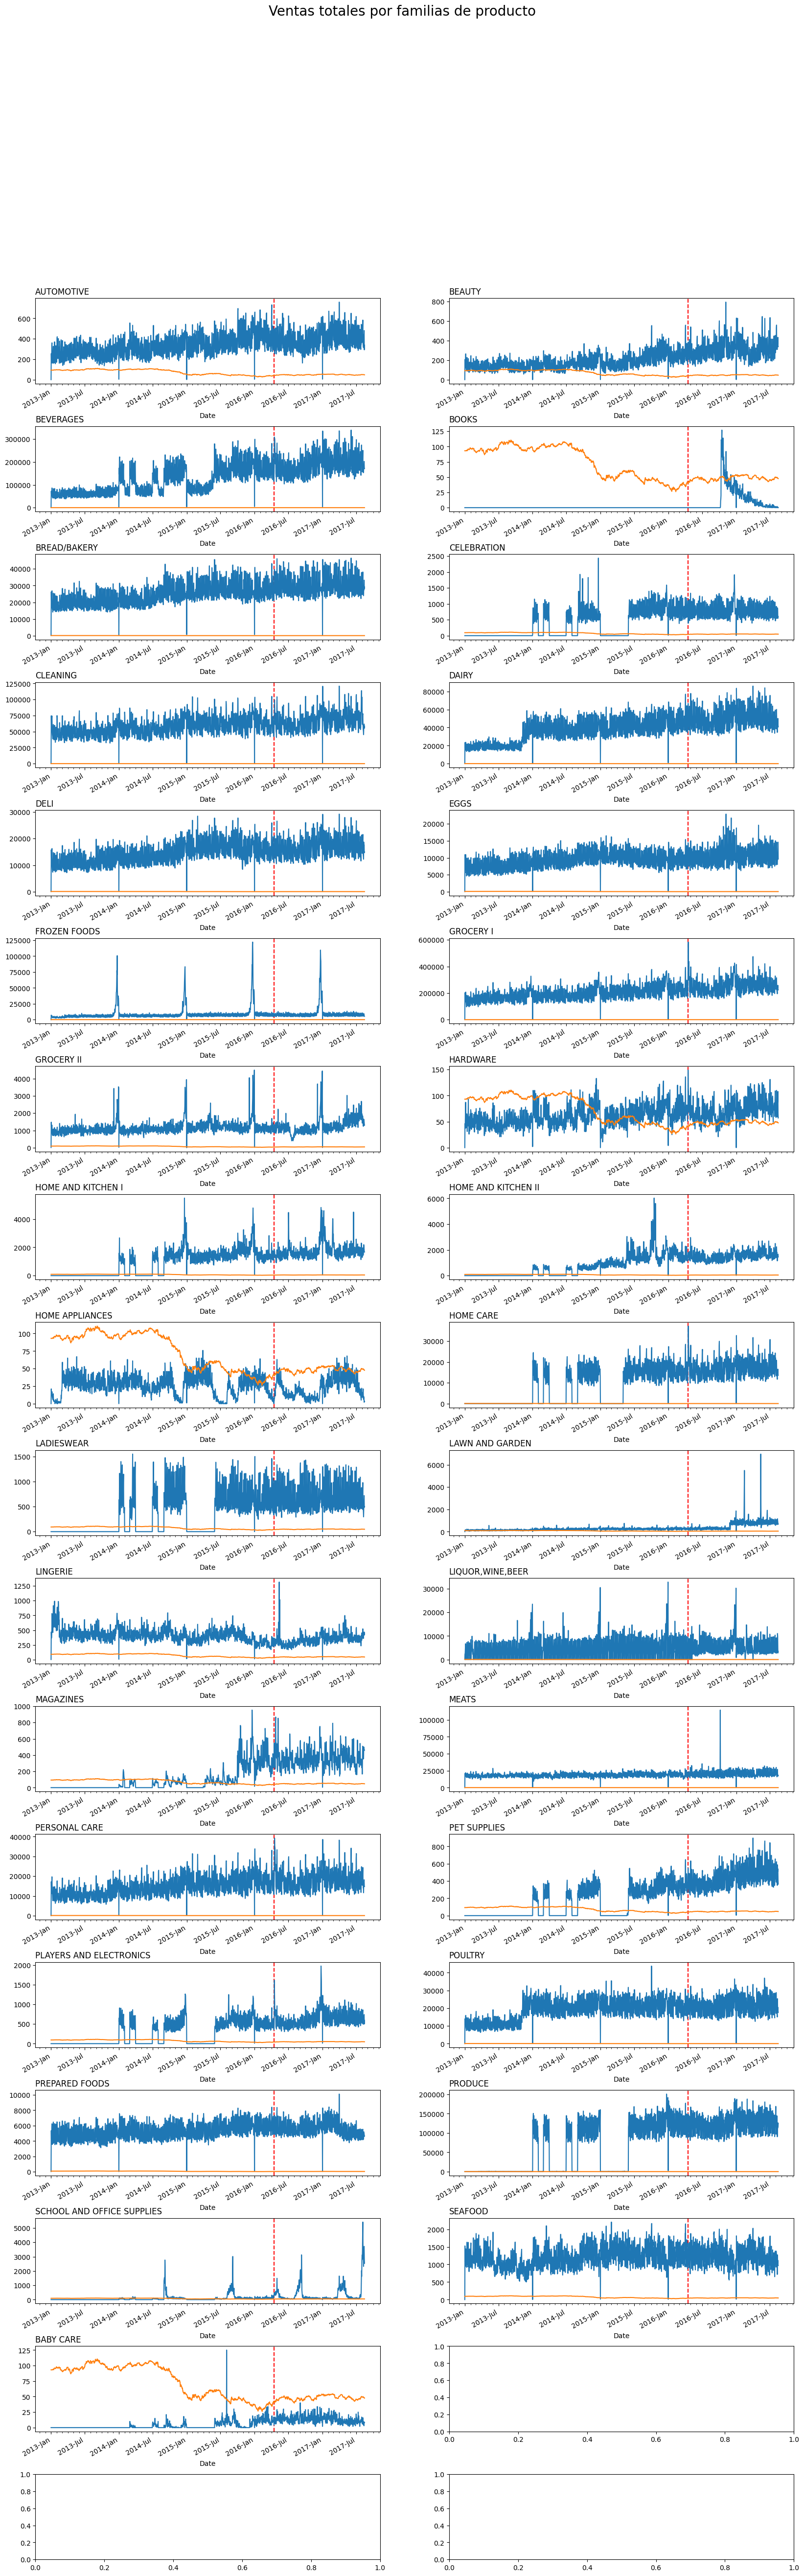

In [ ]:
import matplotlib.dates as mdates

familias = data_processed.family.unique()
fig, axs = plt.subplots(18, 2, figsize=(20,60))
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Ventas totales por familias de producto', fontsize=20)

for f, ax in zip(familias, axs.ravel()):
  ventas_familia = data_processed[data_processed['family'] == f].groupby(['date']).sales.sum().reset_index().sort_values(["date"])
  ventas_familia = pd.merge(ventas_familia, oil_processed, on="date", how="left")

  # Añadimos una marca en el terremoto
  ax.axvline(dt.datetime(2016, 4, 16), color="red", linestyle="--")

  ax.plot(ventas_familia['date'], ventas_familia['sales'])
  ax.plot(ventas_familia['date'], ventas_familia['dcoilwtico'])
  ax.set_title(f, loc="left")

  # Major ticks every half year, minor ticks every month,
  ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
  ax.xaxis.set_minor_locator(mdates.MonthLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

  for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
  ax.set_xlabel('Date')

plt.show()

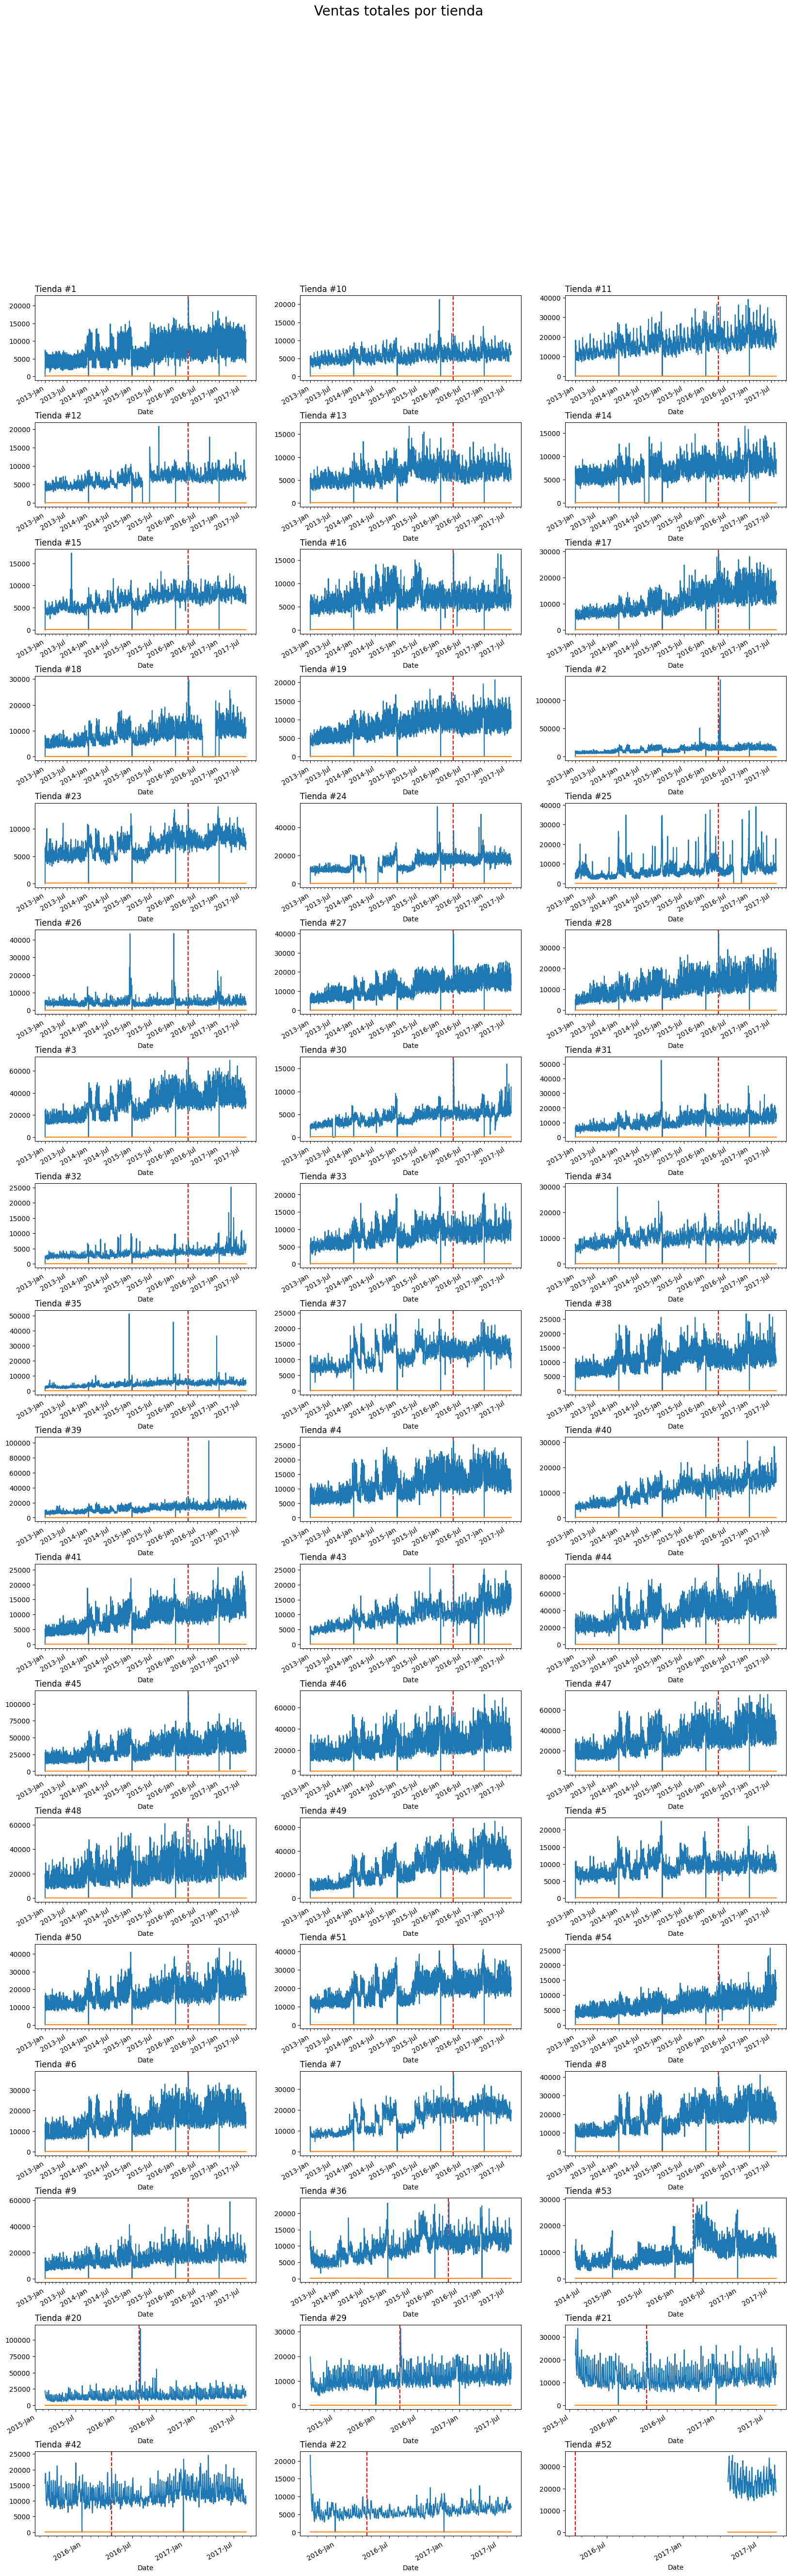

In [ ]:
import matplotlib.dates as mdates

tiendas = data_processed.store_nbr.unique()
fig, axs = plt.subplots(18, 3, figsize=(20,60))
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Ventas totales por tienda', fontsize=20)

for t, ax in zip(tiendas, axs.ravel()):
  ventas_tienda = data_processed[data_processed['store_nbr'] == t].groupby(['date']).sales.sum().reset_index().sort_values(["date"])
  ventas_tienda = pd.merge(ventas_tienda, oil_processed, on="date", how="left")

  # Añadimos una marca en el terremoto
  ax.axvline(dt.datetime(2016, 4, 16), color="red", linestyle="--")

  ax.plot(ventas_tienda['date'], ventas_tienda['sales'])
  ax.plot(ventas_tienda['date'], ventas_tienda['dcoilwtico'])
  ax.set_title('Tienda #' + str(t), loc="left")

  # Major ticks every half year, minor ticks every month,
  ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
  ax.xaxis.set_minor_locator(mdates.MonthLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

  for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
  ax.set_xlabel('Date')

plt.show()

In [ ]:
import matplotlib.dates as mdates

familias = data_processed.family.unique()
tiendas = data_processed.store_nbr.unique()

for t in tiendas:
  fig, axs = plt.subplots(18, 2, figsize=(20,60))
  plt.subplots_adjust(hspace=0.5)
  fig.suptitle('Tienda #' + str(t) + '\nVentas totales por familia de producto', fontsize=20)

  ventas_tienda = data_processed[data_processed['store_nbr'] == t].sort_values(['store_nbr'])

  for f, ax in zip(familias, axs.ravel()):
    # ventas_familia = data_processed[data_processed['family'] == f].groupby(['date']).sales.sum().reset_index().sort_values(["date"])
    ventas_familia = ventas_tienda[ventas_tienda['family'] == f].groupby(['date']).sales.sum().reset_index().sort_values(["date"])
    ventas_familia = pd.merge(ventas_familia, oil_processed, on="date", how="left")

    # Añadimos una marca en el terremoto
    ax.axvline(dt.datetime(2016, 4, 16), color="red", linestyle="--")

    ax.plot(ventas_familia['date'], ventas_familia['sales'])
    ax.plot(ventas_familia['date'], ventas_familia['dcoilwtico'])
    ax.set_title(f, loc="left")

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    for label in ax.get_xticklabels(which='major'):
      label.set(rotation=30, horizontalalignment='right')
    ax.set_xlabel('Date')

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

No he completado la accion para todas las tiendas, pero se ve una tendencia descendente en la mayoría de ellas y para muchas familias a partir de finales de 2014.

In [ ]:
import matplotlib.dates as mdates

familias = data_processed.family.unique()
tiendas = data_processed.store_nbr.unique()
# familias = familias[:2]
# tiendas = tiendas[:5]

for f in familias:
  fig, axs = plt.subplots(len(tiendas), 1, figsize=(10,2*len(tiendas)))
  plt.subplots_adjust(hspace=2)
  fig.suptitle('Familia ' + str(f) + '\nVentas por tiendas', fontsize=8)

  ventas_familia = data_processed[data_processed['family'] == f].sort_values(['family'])

  for t, ax in zip(tiendas, axs.ravel()):
    ventas_tienda = ventas_familia[ventas_familia['store_nbr'] == t].groupby(['date']).sales.sum().reset_index().sort_values(["date"])
    # ventas_tienda = pd.merge(ventas_tienda, oil_processed, on="date", how="left")

    # Añadimos una marca en el terremoto
    ax.axvline(dt.datetime(2016, 4, 16), color="red", linestyle="--")

    ax.plot(ventas_tienda['date'], ventas_tienda['sales'])
    # ax.plot(ventas_tienda['date'], ventas_tienda['dcoilwtico'])
    ax.set_title(f + ' - tienda #' + str(t), loc="left", fontsize=8)

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    for label in ax.get_xticklabels(which='major'):
      label.set(rotation=30, horizontalalignment='right', fontsize=8)
    # ax.set_xlabel('Date')

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import matplotlib.dates as mdates

familias = data_processed.family.unique()
tiendas = data_processed.store_nbr.unique()
# familias = familias[:2]
# tiendas = tiendas[:10]

for f in familias:
  fig, axs = plt.subplots(len(tiendas), 1, figsize=(10,2*len(tiendas)))
  plt.subplots_adjust(hspace=2)
  fig.suptitle('Familia ' + str(f) + '\nVentas por tiendas', fontsize=8)

  ventas_familia = data_processed[data_processed['family'] == f].sort_values(['family'])

  for t, ax in zip(tiendas, axs.ravel()):
    ventas_tienda = data_processed[data_processed['store_nbr'] == t].groupby(['date']).sales.sum().reset_index().sort_values(["date"])
    ventas_tienda = pd.merge(ventas_tienda, oil_processed, on="date", how="left")

    # Añadimos una marca en el terremoto
    ax.axvline(dt.datetime(2016, 4, 16), color="red", linestyle="--")

    ax.plot(ventas_tienda['date'], ventas_tienda['sales'])
    ax.plot(ventas_tienda['date'], ventas_tienda['dcoilwtico'])
    ax.set_title(f + ' - tienda #' + str(t), loc="left", fontsize=8)

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    for label in ax.get_xticklabels(which='major'):
      label.set(rotation=30, horizontalalignment='right', fontsize=8)
    ax.set_xlabel('Date')

  plt.show()

# Juntar datasets

## Añadir datos de cada tienda

In [ ]:
#Existe un dataset de tiendas, el cual tiene los datos de cada tienda, según el valor store_nbr.
#Los dataset train y test tienen una columna llamada store_nbr.
#Vamos ainsertar los datos de cada tienda en los dataset train y test.

data_processed = pd.merge(data_processed, stores_processed, on="store_nbr", how="left")
data_processed.head()

,id,date,store_nbr,family,sales,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,1,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,1,1,1,4.666667,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,1,1,1,0.000000,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,1,1,3.700000,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,1,1,1,2227.433333,Quito,Pichincha,D,13


In [ ]:
test_processed = pd.merge (test_processed, stores_processed, on="store_nbr", how="left")
test_processed.head()

,id,date,store_nbr,family,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,type,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,8,16,2,2.500000,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,8,16,2,10.133333,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,8,16,2,8.766667,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,8,16,2,1.033333,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,8,16,2,4.633333,Quito,Pichincha,D,13


## Añadir precio del petróleo

In [ ]:
#Vamos a incorporar ahora el valor del oil en los dos dataset

if 'dcoilwtico' not in data_processed.columns:
  data_processed = pd.merge(data_processed, oil_processed, on="date", how="left")
data_processed.head()

if 'dcoilwtico' not in test_processed.columns:
  test_processed = pd.merge(test_processed, oil_processed, on="date", how="left")
test_processed.head()

,id,date,store_nbr,family,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,type,cluster,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,8,16,2,2.500000,Quito,Pichincha,D,13,46.8
1,3000889,2017-08-16,1,BABY CARE,0,8,16,2,10.133333,Quito,Pichincha,D,13,46.8
2,3000890,2017-08-16,1,BEAUTY,2,8,16,2,8.766667,Quito,Pichincha,D,13,46.8
3,3000891,2017-08-16,1,BEVERAGES,20,8,16,2,1.033333,Quito,Pichincha,D,13,46.8
4,3000892,2017-08-16,1,BOOKS,0,8,16,2,4.633333,Quito,Pichincha,D,13,46.8


## Añadir vacaciones

In [ ]:
# Vamos a incorporar ahora la información sobre vacaciones en ambos dataset
# Creo que primero habría que hacer algo con las vacaciones "Transferred", pero no veo la forma de ver a qué día se han transferido las mismas.



In [ ]:
# Quitar las fechas de vacaciones anteriores al dataset de ventas, no nos valen para nada
holidays_events_processed = holidays_events_processed[~(holidays_events_processed['date'] < '2013-01-01')]
holidays_events_processed

,date,type,locale,locale_name,description,transferred
41,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
44,2013-02-11,Holiday,National,Ecuador,Carnaval,False
45,2013-02-12,Holiday,National,Ecuador,Carnaval,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [ ]:
# Desdoblar en los datos de holidays la columna locale_name en "city" y "estate" según el tipo de festivo
# holidays_events_processed['city'] = holidays_events_processed.apply(lambda x: x['locale_name'] if x['locale'] == 'Local' else 0, axis=1)
# holidays_events_processed['state'] = holidays_events_processed.apply(lambda x: x['locale_name'] if x['locale'] == 'Regional' else 0, axis=1)
# holidays_events_processed['country'] = holidays_events_processed.apply(lambda x: x['locale_name'] if x['locale'] == 'National' else 0, axis=1)
# holidays_events_processed

In [ ]:
#Los valores que me interesan incorporar de holidays_events a data son type, description y transferred
#Las condiciones que se han de dar para incorporarlos son:

# 1. Los valores de las columnas date en los dos dataset coinciden, y;
# 2. Si en el dataset holidays_events el valor de locale es Local y el valor de "locale_name" coincide con el valor de "city" en el dataset data, o;
# 3. Si en el dataset holidays_events el valor de locale es Regional y el valor de "locale_name" coincide con el valor de "state" en el dataset data
# 4. Si en el dataset holidays_events el valor de locale es National

from datetime import datetime

data_processed['holiday_locale'] = np.nan
data_processed['holiday_type'] = np.nan
test_processed['holiday_locale'] = np.nan
test_processed['holiday_type'] = np.nan

for index, holiday_row in holidays_events_processed.iterrows():
    print( '\n-----\nHOLIDAY: ' + str(holiday_row['date']) + ' - ' + holiday_row['locale'] + ' - ' + str(holiday_row['locale_name']))
    if holiday_row['locale'] == 'National':
      # print(str(data_processed.loc[ data_processed['date'] == holiday_row['date']].shape[0]/33) + ' tiendas encontradas')
      data_processed.loc[ data_processed['date'] == holiday_row['date'], 'holiday_locale'] = holiday_row['locale']
      data_processed.loc[ data_processed['date'] == holiday_row['date'], 'holiday_type'] = holiday_row['type']
      test_processed.loc[ test_processed['date'] == holiday_row['date'], 'holiday_locale'] = holiday_row['locale']
      test_processed.loc[ test_processed['date'] == holiday_row['date'], 'holiday_type'] = holiday_row['type']
    elif holiday_row['locale'] == 'Regional':
      # print(str(data_processed.loc[ (data_processed['date'] == holiday_row['date']) & (data_processed['state'] == holiday_row['locale_name'])].shape[0]/33) + ' tiendas encontradas')
      data_processed.loc[ (data_processed['date'] == holiday_row['date']) & (data_processed['state'] == holiday_row['locale_name']), 'holiday_locale'] = holiday_row['locale']
      data_processed.loc[ (data_processed['date'] == holiday_row['date']) & (data_processed['state'] == holiday_row['locale_name']), 'holiday_type'] = holiday_row['type']
      test_processed.loc[ (test_processed['date'] == holiday_row['date']) & (test_processed['state'] == holiday_row['locale_name']), 'holiday_locale'] = holiday_row['locale']
      test_processed.loc[ (test_processed['date'] == holiday_row['date']) & (test_processed['state'] == holiday_row['locale_name']), 'holiday_type'] = holiday_row['type']
    else:
      # print(str(data_processed.loc[ (data_processed['date'] == holiday_row['date']) & (data_processed['city'] == holiday_row['locale_name'])].shape[0]/33) + ' tiendas encontradas')
      data_processed.loc[ (data_processed['date'] == holiday_row['date']) & (data_processed['city'] == holiday_row['locale_name']), 'holiday_locale'] = holiday_row['locale']
      data_processed.loc[ (data_processed['date'] == holiday_row['date']) & (data_processed['city'] == holiday_row['locale_name']), 'holiday_type'] = holiday_row['type']
      test_processed.loc[ (test_processed['date'] == holiday_row['date']) & (test_processed['city'] == holiday_row['locale_name']), 'holiday_locale'] = holiday_row['locale']
      test_processed.loc[ (test_processed['date'] == holiday_row['date']) & (test_processed['city'] == holiday_row['locale_name']), 'holiday_type'] = holiday_row['type']



-----
HOLIDAY: 2013-01-01 00:00:00 - National - Ecuador

-----
HOLIDAY: 2013-01-05 00:00:00 - National - Ecuador

-----
HOLIDAY: 2013-01-12 00:00:00 - National - Ecuador

-----
HOLIDAY: 2013-02-11 00:00:00 - National - Ecuador

-----
HOLIDAY: 2013-02-12 00:00:00 - National - Ecuador

-----
HOLIDAY: 2013-03-02 00:00:00 - Local - Manta

-----
HOLIDAY: 2013-04-01 00:00:00 - Regional - Cotopaxi

-----
HOLIDAY: 2013-04-12 00:00:00 - Local - Cuenca

-----
HOLIDAY: 2013-04-14 00:00:00 - Local - Libertad

-----
HOLIDAY: 2013-04-21 00:00:00 - Local - Riobamba

-----
HOLIDAY: 2013-04-29 00:00:00 - National - Ecuador

-----
HOLIDAY: 2013-05-01 00:00:00 - National - Ecuador

-----
HOLIDAY: 2013-05-11 00:00:00 - National - Ecuador

-----
HOLIDAY: 2013-05-12 00:00:00 - Local - Puyo

-----
HOLIDAY: 2013-05-12 00:00:00 - National - Ecuador

-----
HOLIDAY: 2013-05-24 00:00:00 - National - Ecuador

-----
HOLIDAY: 2013-06-23 00:00:00 - Local - Guaranda

-----
HOLIDAY: 2013-06-25 00:00:00 - Regional - Im

In [ ]:
data_processed.sample(20)

,id,date,store_nbr,family,sales,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,type,cluster,dcoilwtico,holiday_locale,holiday_type
2669940,2890512,2017-06-15,12,DELI,182.0,1,6,15,3,0.366667,Latacunga,Cotopaxi,C,15,44.470000,NaN,NaN
181098,212613,2013-04-30,24,PLAYERS AND ELECTRONICS,0.0,0,4,30,1,13.100000,Guayaquil,Guayas,D,1,93.220000,NaN,NaN
1662588,1866033,2015-11-16,17,HOME AND KITCHEN I,23.0,0,11,16,0,174.000000,Quito,Pichincha,C,12,41.680000,NaN,NaN
1747217,1952246,2016-01-04,35,SEAFOOD,0.0,0,1,4,0,0.566667,Playas,Guayas,C,3,36.810000,NaN,NaN
2662917,2883489,2017-06-11,15,HOME AND KITCHEN I,15.0,6,6,11,6,66.398133,Ibarra,Imbabura,C,15,46.006667,NaN,NaN
2329275,2545293,2016-12-02,26,BEVERAGES,1432.0,60,12,2,4,79.473233,Guayaquil,Guayas,D,10,51.700000,NaN,NaN
1193215,1366135,2015-02-08,40,BABY CARE,0.0,0,2,8,6,73.733333,Machala,El Oro,C,3,52.546667,NaN,NaN
937415,1078325,2014-08-30,15,HOME APPLIANCES,0.0,0,8,30,5,2880.667900,Ibarra,Imbabura,C,15,96.625000,NaN,NaN
1486753,1684225,2015-08-06,16,BOOKS,0.0,0,8,6,3,5.600000,Santo Domingo,Santo Domingo de los Tsachilas,C,3,44.690000,NaN,NaN
459052,532279,2013-10-26,43,"LIQUOR,WINE,BEER",252.0,0,10,26,5,635.833333,Esmeraldas,Esmeraldas,E,10,97.846667,NaN,NaN


In [ ]:
test_processed.sample(20)

,id,date,store_nbr,family,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,type,cluster,dcoilwtico,holiday_locale,holiday_type
8835,3009723,2017-08-20,7,MEATS,0,8,20,6,0.000000,Quito,Pichincha,D,8,47.790000,NaN,NaN
9669,3010557,2017-08-21,30,AUTOMOTIVE,0,8,21,0,137.200000,Guayaquil,Guayas,C,3,47.390000,NaN,NaN
15757,3016645,2017-08-24,50,HOME AND KITCHEN II,2,8,24,3,0.000000,Ambato,Tungurahua,A,14,47.240000,Local,Holiday
2549,3003437,2017-08-17,30,DAIRY,11,8,17,3,167.200000,Guayaquil,Guayas,C,3,47.070000,NaN,NaN
23824,3024712,2017-08-29,27,SCHOOL AND OFFICE SUPPLIES,0,8,29,1,54.015233,Daule,Guayas,D,1,46.460000,NaN,NaN
19467,3020355,2017-08-26,54,PRODUCE,0,8,26,5,2.900000,El Carmen,Manabi,C,3,47.233333,NaN,NaN
21489,3022377,2017-08-28,12,CELEBRATION,0,8,28,0,0.000000,Latacunga,Cotopaxi,C,15,46.400000,NaN,NaN
17025,3017913,2017-08-25,36,PRODUCE,1,8,25,4,2.966667,Libertad,Guayas,E,10,47.650000,NaN,NaN
20059,3020947,2017-08-27,21,POULTRY,0,8,27,6,21.566667,Santo Domingo,Santo Domingo de los Tsachilas,B,6,46.816667,NaN,NaN
17700,3018588,2017-08-25,6,GROCERY I,48,8,25,4,0.133333,Quito,Pichincha,D,13,47.650000,NaN,NaN


In [ ]:

# Comprobación aleatoria de los datos

#Festivo local en Cuenca
# data_processed.loc[prueba_data['date'] == '2014-04-12 00:00:00']

#Festivo regional en Cotopaxi
data_processed.loc[data_processed['date'] == '2014-04-01 00:00:00']

#Festivo nacional
# data_processed.loc[prueba_data['date'] == '2014-01-01 00:00:00']

,id,date,store_nbr,family,sales,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,type,cluster,dcoilwtico,holiday_locale,holiday_type
699930,809028,2014-04-01,1,AUTOMOTIVE,10.000,0,4,1,1,3.000000,Quito,Pichincha,D,13,99.69,NaN,NaN
699931,809029,2014-04-01,1,BABY CARE,0.000,0,4,1,1,0.000000,Quito,Pichincha,D,13,99.69,NaN,NaN
699932,809030,2014-04-01,1,BEAUTY,3.000,0,4,1,1,2.200000,Quito,Pichincha,D,13,99.69,NaN,NaN
699933,809031,2014-04-01,1,BEVERAGES,1096.000,0,4,1,1,1754.700000,Quito,Pichincha,D,13,99.69,NaN,NaN
699934,809032,2014-04-01,1,BOOKS,0.000,0,4,1,1,0.000000,Quito,Pichincha,D,13,99.69,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701476,810805,2014-04-01,9,POULTRY,704.912,0,4,1,1,472.933333,Quito,Pichincha,B,6,99.69,NaN,NaN
701477,810806,2014-04-01,9,PREPARED FOODS,95.755,0,4,1,1,0.000000,Quito,Pichincha,B,6,99.69,NaN,NaN
701478,810807,2014-04-01,9,PRODUCE,0.000,0,4,1,1,0.000000,Quito,Pichincha,B,6,99.69,NaN,NaN
701479,810808,2014-04-01,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,4,1,1,503.150133,Quito,Pichincha,B,6,99.69,NaN,NaN


## Añadir terremoto

In [ ]:
data_processed['event_earthquake'] = 0
test_processed['event_earthquake'] = 0
data_processed.loc[data_processed['date'] == '2016-04-16 00:00:00', 'event_earthquake'] = 1

# Normalización de variables categóricas

In [ ]:
#Leemos cuantos valores distintos hay en las columnas con datos categóricos en data_processed

valores_family = data_processed["family"].unique()
print(valores_family)

valores_city = data_processed["city"].unique()
print(valores_city)

valores_state = data_processed["state"].unique()
print(valores_state)

valores_type = data_processed["type"].unique()
print(valores_type)

valores_holiday_locale = data_processed["holiday_locale"].unique()
print(valores_holiday_locale)

valores_holiday_type = data_processed["holiday_type"].unique()
print(valores_holiday_type)

valores_event_earthquake = data_processed["event_earthquake"].unique()
print(valores_event_earthquake)

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
['Quito' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra' 'Santo Domingo'
 'Guaranda' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo' 'Quevedo'
 'Playas' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas' 'El Carmen' 'Libertad'
 'Manta' 'Puyo']
['Pichincha' 'Cotopaxi' 'Chimborazo' 'Imbabura'
 'Santo Domingo de los Tsachilas' 'Bolivar' 'Tungurahua' 'Guayas'
 'Santa Elena' 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi'
 'Pastaza']
['D' 'C' 'B' 'E' 'A']
['National' nan 'Regional' 'Local']
['Holiday' nan 'Work Day' 'Additional' 'Event' 'Transf

In [ ]:
#Leemos cuantos valores distintos hay en las columnas con datos categóricos en test_processed

valores_family_test = test_processed["family"].unique()
print(valores_family_test)

valores_city_test = test_processed["city"].unique()
print(valores_city_test)

valores_state_test = test_processed["state"].unique()
print(valores_state_test)

valores_type_test = test_processed["type"].unique()
print(valores_type_test)

valores_holiday_locale_test = test_processed["holiday_locale"].unique()
print(valores_holiday_locale_test)

valores_holiday_type_test = test_processed["holiday_type"].unique()
print(valores_holiday_type_test)

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
['Quito' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra' 'Santo Domingo'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']
['Pichincha' 'Cotopaxi' 'Chimborazo' 'Imbabura'
 'Santo Domingo de los Tsachilas' 'Bolivar' 'Pastaza' 'Tungurahua'
 'Guayas' 'Santa Elena' 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas'
 'Manabi']
['D' 'C' 'B' 'E' 'A']
[nan 'Local']
[nan 'Holiday']


In [ ]:
#Los valores en las columnas con variables categóricas son los mismos en ambos datasets, excepto en las columnas holyday_locale y holiday_type, donde hay mas valores diferentes en data que en test.
#Por esta razón, vamos a condificar las variables categóricas de la siguiente forma:

#Target encoding para las columnas family, city y state.
#One-hot encoding para la columna type.
#Label encoding para las columnas holiday_locale y holiday_type.


In [ ]:
# Target Encoding
tenc = ce.TargetEncoder()
target_encoding_columns = ['family', 'city', 'state']
a = data_processed
a['family_name'] = a['family']
print(a.columns)
b = test_processed
b['family_name'] = b['family']
b["sales"] = 0
all = pd.concat([a, b])
for c in target_encoding_columns:
  temp_encoded = tenc.fit_transform(all[c],all['sales'])
  all[c] = temp_encoded

a = all[(all.date <= "2017-08-15")]
b = all[(all.date > "2017-08-15")]
data_processed = a
test_processed = b

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'month',
       'day', 'day_of_week', 'sales_media_movil_30_dias_lag16', 'city',
       'state', 'type', 'cluster', 'dcoilwtico', 'holiday_locale',
       'holiday_type', 'event_earthquake', 'family_name'],
      dtype='object')


In [ ]:
data_processed

,id,date,store_nbr,family,sales,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,type,cluster,dcoilwtico,holiday_locale,holiday_type,event_earthquake,family_name
0,0,2013-01-01,1,6.518422,0.000,0,1,1,1,NaN,565.589351,562.317708,D,13,93.14,National,Holiday,0,AUTOMOTIVE
1,1,2013-01-01,1,0.118086,0.000,0,1,1,1,4.666667,565.589351,562.317708,D,13,93.14,National,Holiday,0,BABY CARE
2,2,2013-01-01,1,3.969794,0.000,0,1,1,1,0.000000,565.589351,562.317708,D,13,93.14,National,Holiday,0,BEAUTY
3,3,2013-01-01,1,2548.927182,0.000,0,1,1,1,3.700000,565.589351,562.317708,D,13,93.14,National,Holiday,0,BEVERAGES
4,4,2013-01-01,1,0.075638,0.000,0,1,1,1,2227.433333,565.589351,562.317708,D,13,93.14,National,Holiday,0,BOOKS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2780311,3000883,2017-08-15,9,374.500734,438.133,0,8,15,1,2.633333,565.589351,562.317708,B,6,47.57,NaN,NaN,0,POULTRY
2780312,3000884,2017-08-15,9,103.387085,154.553,1,8,15,1,7.633333,565.589351,562.317708,B,6,47.57,NaN,NaN,0,PREPARED FOODS
2780313,3000885,2017-08-15,9,1441.617142,2419.729,148,8,15,1,596.142265,565.589351,562.317708,B,6,47.57,NaN,NaN,0,PRODUCE
2780314,3000886,2017-08-15,9,3.164105,121.000,8,8,15,1,77.572233,565.589351,562.317708,B,6,47.57,NaN,NaN,0,SCHOOL AND OFFICE SUPPLIES


In [ ]:
test_processed

,id,date,store_nbr,family,sales,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,type,cluster,dcoilwtico,holiday_locale,holiday_type,event_earthquake,family_name
0,3000888,2017-08-16,1,6.518422,0.0,0,8,16,2,2.500000,565.589351,562.317708,D,13,46.80,NaN,NaN,0,AUTOMOTIVE
1,3000889,2017-08-16,1,0.118086,0.0,0,8,16,2,10.133333,565.589351,562.317708,D,13,46.80,NaN,NaN,0,BABY CARE
2,3000890,2017-08-16,1,3.969794,0.0,2,8,16,2,8.766667,565.589351,562.317708,D,13,46.80,NaN,NaN,0,BEAUTY
3,3000891,2017-08-16,1,2548.927182,0.0,20,8,16,2,1.033333,565.589351,562.317708,D,13,46.80,NaN,NaN,0,BEVERAGES
4,3000892,2017-08-16,1,0.075638,0.0,0,8,16,2,4.633333,565.589351,562.317708,D,13,46.80,NaN,NaN,0,BOOKS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,374.500734,0.0,1,8,31,3,237.833333,565.589351,562.317708,B,6,47.26,NaN,NaN,0,POULTRY
28508,3029396,2017-08-31,9,103.387085,0.0,0,8,31,3,249.533333,565.589351,562.317708,B,6,47.26,NaN,NaN,0,PREPARED FOODS
28509,3029397,2017-08-31,9,1441.617142,0.0,1,8,31,3,173.266667,565.589351,562.317708,B,6,47.26,NaN,NaN,0,PRODUCE
28510,3029398,2017-08-31,9,3.164105,0.0,9,8,31,3,NaN,565.589351,562.317708,B,6,47.26,NaN,NaN,0,SCHOOL AND OFFICE SUPPLIES


In [ ]:
# One hot encoding
data_processed = pd.get_dummies(data_processed, columns=['type'])
test_processed = pd.get_dummies(test_processed, columns=['type'])


In [ ]:
#Label encoding

cleanup_nums = {
    "holiday_locale":         {"National": 1, "Regional": 2, "Local": 3},
    "holiday_type":           {"Holiday": 1, "Work Day": 2, "Additional": 3, "Event": 4, "Transfer": 5, "Bridge": 6},
    }

data_processed = data_processed.replace(cleanup_nums)
test_processed = test_processed.replace(cleanup_nums)

In [ ]:
#Se ven algunos valores NaN, así que vamos a comrpobar en qué columnas hay

columnas_nan_data = data_processed.isna().any()
columnas_nan_test = test_processed.isna().any()

columnas_nan_data

id                                 False
date                               False
store_nbr                          False
family                             False
sales                              False
onpromotion                        False
month                              False
day                                False
day_of_week                        False
sales_media_movil_30_dias_lag16     True
city                               False
state                              False
cluster                            False
dcoilwtico                         False
holiday_locale                      True
holiday_type                        True
event_earthquake                   False
family_name                        False
type_A                             False
type_B                             False
type_C                             False
type_D                             False
type_E                             False
dtype: bool

In [ ]:
columnas_nan_test

id                                 False
date                               False
store_nbr                          False
family                             False
sales                              False
onpromotion                        False
month                              False
day                                False
day_of_week                        False
sales_media_movil_30_dias_lag16     True
city                               False
state                              False
cluster                            False
dcoilwtico                         False
holiday_locale                      True
holiday_type                        True
event_earthquake                   False
family_name                        False
type_A                             False
type_B                             False
type_C                             False
type_D                             False
type_E                             False
dtype: bool

In [ ]:
#Reemplazar los valores NaN por 0, ya que con el label encoding directamente no se puede
data_processed[['sales_media_movil_30_dias_lag16', 'holiday_locale', 'holiday_type']] = data_processed[['sales_media_movil_30_dias_lag16', 'holiday_locale', 'holiday_type']].fillna(0)
test_processed[['sales_media_movil_30_dias_lag16', 'holiday_locale', 'holiday_type']] = test_processed[['sales_media_movil_30_dias_lag16', 'holiday_locale', 'holiday_type']].fillna(0)


In [ ]:
# Convertir columnas float64 en int64
data_processed['holiday_locale'] = data_processed['holiday_locale'].astype(np.int64)
data_processed['holiday_type'] = data_processed['holiday_type'].astype(np.int64)
test_processed['holiday_locale'] = test_processed['holiday_locale'].astype(np.int64)
test_processed['holiday_type'] = test_processed['holiday_type'].astype(np.int64)

In [ ]:
data_processed

,id,date,store_nbr,family,sales,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,cluster,dcoilwtico,holiday_locale,holiday_type,event_earthquake,family_name,type_A,type_B,type_C,type_D,type_E
0,0,2013-01-01,1,6.518422,0.000,0,1,1,1,0.000000,565.589351,562.317708,13,93.14,1,1,0,AUTOMOTIVE,0,0,0,1,0
1,1,2013-01-01,1,0.118086,0.000,0,1,1,1,4.666667,565.589351,562.317708,13,93.14,1,1,0,BABY CARE,0,0,0,1,0
2,2,2013-01-01,1,3.969794,0.000,0,1,1,1,0.000000,565.589351,562.317708,13,93.14,1,1,0,BEAUTY,0,0,0,1,0
3,3,2013-01-01,1,2548.927182,0.000,0,1,1,1,3.700000,565.589351,562.317708,13,93.14,1,1,0,BEVERAGES,0,0,0,1,0
4,4,2013-01-01,1,0.075638,0.000,0,1,1,1,2227.433333,565.589351,562.317708,13,93.14,1,1,0,BOOKS,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2780311,3000883,2017-08-15,9,374.500734,438.133,0,8,15,1,2.633333,565.589351,562.317708,6,47.57,0,0,0,POULTRY,0,1,0,0,0
2780312,3000884,2017-08-15,9,103.387085,154.553,1,8,15,1,7.633333,565.589351,562.317708,6,47.57,0,0,0,PREPARED FOODS,0,1,0,0,0
2780313,3000885,2017-08-15,9,1441.617142,2419.729,148,8,15,1,596.142265,565.589351,562.317708,6,47.57,0,0,0,PRODUCE,0,1,0,0,0
2780314,3000886,2017-08-15,9,3.164105,121.000,8,8,15,1,77.572233,565.589351,562.317708,6,47.57,0,0,0,SCHOOL AND OFFICE SUPPLIES,0,1,0,0,0


In [ ]:
test_processed

,id,date,store_nbr,family,sales,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,cluster,dcoilwtico,holiday_locale,holiday_type,event_earthquake,family_name,type_A,type_B,type_C,type_D,type_E
0,3000888,2017-08-16,1,6.518422,0.0,0,8,16,2,2.500000,565.589351,562.317708,13,46.80,0,0,0,AUTOMOTIVE,0,0,0,1,0
1,3000889,2017-08-16,1,0.118086,0.0,0,8,16,2,10.133333,565.589351,562.317708,13,46.80,0,0,0,BABY CARE,0,0,0,1,0
2,3000890,2017-08-16,1,3.969794,0.0,2,8,16,2,8.766667,565.589351,562.317708,13,46.80,0,0,0,BEAUTY,0,0,0,1,0
3,3000891,2017-08-16,1,2548.927182,0.0,20,8,16,2,1.033333,565.589351,562.317708,13,46.80,0,0,0,BEVERAGES,0,0,0,1,0
4,3000892,2017-08-16,1,0.075638,0.0,0,8,16,2,4.633333,565.589351,562.317708,13,46.80,0,0,0,BOOKS,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,374.500734,0.0,1,8,31,3,237.833333,565.589351,562.317708,6,47.26,0,0,0,POULTRY,0,1,0,0,0
28508,3029396,2017-08-31,9,103.387085,0.0,0,8,31,3,249.533333,565.589351,562.317708,6,47.26,0,0,0,PREPARED FOODS,0,1,0,0,0
28509,3029397,2017-08-31,9,1441.617142,0.0,1,8,31,3,173.266667,565.589351,562.317708,6,47.26,0,0,0,PRODUCE,0,1,0,0,0
28510,3029398,2017-08-31,9,3.164105,0.0,9,8,31,3,0.000000,565.589351,562.317708,6,47.26,0,0,0,SCHOOL AND OFFICE SUPPLIES,0,1,0,0,0


In [ ]:
#Comprobamos que todos los datos son de tipo numérico o fecha

data_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2780316 entries, 0 to 2780315
Data columns (total 23 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   id                               int64         
 1   date                             datetime64[ns]
 2   store_nbr                        int64         
 3   family                           float64       
 4   sales                            float64       
 5   onpromotion                      int64         
 6   month                            int64         
 7   day                              int64         
 8   day_of_week                      int64         
 9   sales_media_movil_30_dias_lag16  float64       
 10  city                             float64       
 11  state                            float64       
 12  cluster                          int64         
 13  dcoilwtico                       float64       
 14  holiday_locale                   i

In [ ]:
test_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 28511
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   id                               28512 non-null  int64         
 1   date                             28512 non-null  datetime64[ns]
 2   store_nbr                        28512 non-null  int64         
 3   family                           28512 non-null  float64       
 4   sales                            28512 non-null  float64       
 5   onpromotion                      28512 non-null  int64         
 6   month                            28512 non-null  int64         
 7   day                              28512 non-null  int64         
 8   day_of_week                      28512 non-null  int64         
 9   sales_media_movil_30_dias_lag16  28512 non-null  float64       
 10  city                             28512 non-null  float64  

## Correlación de variables

In [ ]:
#Vamos a observar si hay correlación entre variables para ver si podemos eliminar alguna

data_processed.corr()

<ipython-input-222-1b4db301ce5a>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,id,store_nbr,family,sales,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,cluster,dcoilwtico,holiday_locale,holiday_type,event_earthquake,type_A,type_B,type_C,type_D,type_E
id,1.000000,1.734965e-02,-1.783336e-06,0.071124,0.202911,5.999469e-02,5.247040e-03,-1.624221e-03,-0.011358,-2.008998e-02,-2.605399e-02,-1.212296e-02,-8.356350e-01,3.933176e-02,6.361925e-02,1.705762e-02,-1.758356e-02,2.746022e-02,-1.662010e-02,-6.012880e-03,2.893007e-02
store_nbr,0.017350,1.000000e+00,2.082845e-16,0.055948,0.016069,3.366239e-03,1.583721e-04,2.588157e-05,0.062289,-1.963442e-01,-1.977687e-01,-7.953580e-02,-1.432515e-02,-2.860545e-03,8.662671e-04,2.159927e-04,5.807115e-01,-9.545801e-02,-1.093929e-01,-3.481793e-01,1.351912e-01
family,-0.000002,2.082845e-16,1.000000e+00,0.735322,0.365156,2.216818e-15,1.828895e-16,-4.009049e-17,-0.014169,-2.509726e-16,-3.213057e-16,-1.448667e-16,-1.091208e-14,1.172588e-15,1.670093e-15,2.355051e-16,-2.777758e-16,3.402227e-16,-2.090804e-16,-4.905108e-17,4.034189e-16
sales,0.071124,5.594805e-02,7.353215e-01,1.000000,0.424980,1.895270e-02,-1.257287e-02,3.846119e-02,0.013997,1.292633e-01,1.269402e-01,3.583349e-02,-6.164358e-02,1.436049e-02,1.885165e-02,2.349476e-03,1.542731e-01,-4.290652e-03,-1.007584e-01,-1.092569e-02,-1.758386e-02
onpromotion,0.202911,1.606875e-02,3.651562e-01,0.424980,1.000000,2.584671e-02,2.184190e-03,-2.807799e-03,-0.000561,1.927535e-02,1.671278e-02,3.419049e-03,-1.507510e-01,1.706228e-02,2.725715e-02,-1.086085e-03,1.893123e-02,1.398346e-02,-3.171889e-02,1.556925e-03,7.153914e-03
month,0.059995,3.366239e-03,2.216818e-15,0.018953,0.025847,1.000000e+00,1.982724e-03,-5.742654e-03,-0.000498,-2.988415e-03,-3.812590e-03,2.737440e-04,1.194204e-02,7.384455e-02,6.027608e-02,-1.651106e-02,-2.387276e-03,3.914340e-04,-2.660594e-03,5.934699e-04,6.576682e-03
day,0.005247,1.583721e-04,1.828895e-16,-0.012573,0.002184,1.982724e-03,1.000000e+00,1.712380e-03,-0.000127,-1.877725e-04,-2.312442e-04,-6.187486e-05,-1.773688e-03,-3.158972e-02,1.011130e-02,1.042437e-03,-1.957503e-04,1.523373e-04,-2.418717e-04,-1.707600e-04,8.282001e-04
day_of_week,-0.001624,2.588157e-05,-4.009049e-17,0.038461,-0.002808,-5.742654e-03,1.712380e-03,1.000000e+00,-0.000020,-1.886047e-06,-8.393789e-06,2.316996e-05,1.841453e-03,1.109556e-02,2.937983e-02,2.511607e-02,1.877597e-05,-2.083709e-05,-1.740164e-05,-9.573190e-06,5.030512e-05
sales_media_movil_30_dias_lag16,-0.011358,6.228947e-02,-1.416904e-02,0.013997,-0.000561,-4.984266e-04,-1.267858e-04,-2.014395e-05,1.000000,1.255268e-01,1.238710e-01,4.891328e-02,1.146940e-02,-2.971580e-04,-8.769982e-04,-5.928533e-04,1.547811e-01,-4.581262e-03,-9.785126e-02,-1.853480e-02,-8.864128e-03
city,-0.020090,-1.963442e-01,-2.509726e-16,0.129263,0.019275,-2.988415e-03,-1.877725e-04,-1.886047e-06,0.125527,1.000000e+00,9.823044e-01,3.183375e-01,1.651493e-02,1.189303e-03,-5.025641e-04,-5.926220e-04,3.651663e-01,1.401158e-01,-4.708734e-01,1.529828e-01,-1.669721e-01


<ipython-input-223-a7d850c172dd>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



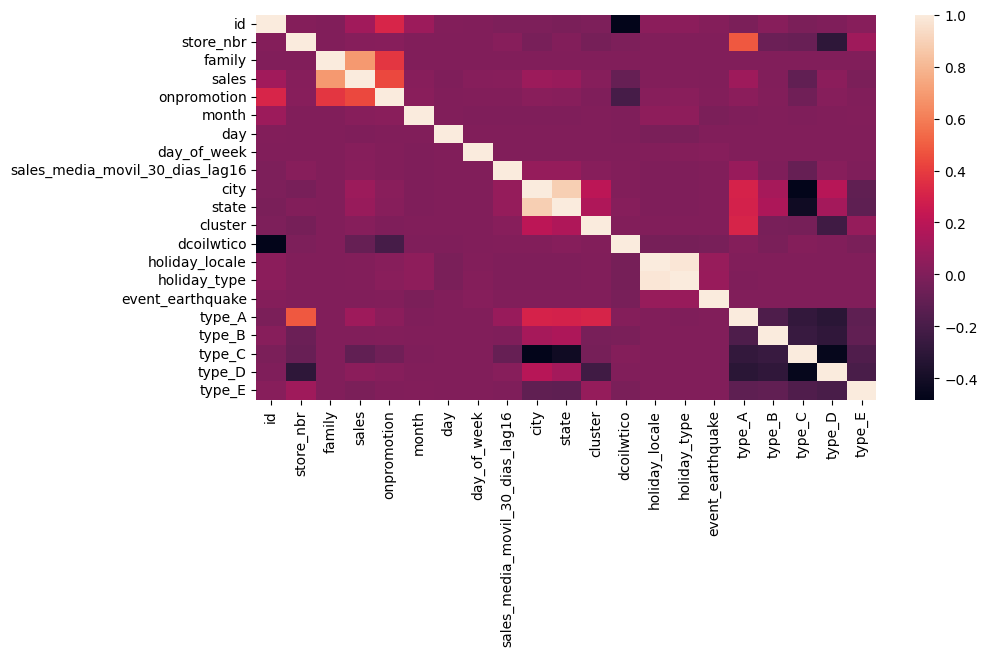

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.heatmap(data_processed.corr(method='kendall'), ax=ax);

In [ ]:
#No se observa una correlación lo suficientemente fuerte entre variables para poder elimianr alguna de ellas.

### Correlación entre ventas y transacciones

In [ ]:
# temp = pd.merge(data_processed.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")
# print("Correlación Spearman entre ventas totales y transacciones: {:,.4f}".format(temp.corr("spearman").sales.loc["transactions"]))
# px.line(transactions.sort_values(["store_nbr", "date"]), x='date', y='transactions', color='store_nbr',title = "Transactions" )

ValueError: ignored

# Guardar el dataset combinado

In [ ]:
# Guardamos el dataset
data_processed.to_csv( os.path.join( rootdir, 'data_processed.csv'), index=False, encoding='utf-8' )
test_processed.to_csv( os.path.join( rootdir, 'test_processed.csv'), index=False, encoding='utf-8' )

## Cargar el dataset combinado

In [ ]:
data_processed = pd.read_csv(os.path.join(rootdir, 'data_processed.csv'))
test_processed = pd.read_csv(os.path.join(rootdir, 'test_processed.csv'))

In [ ]:
data_processed

,id,date,store_nbr,family,sales,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,cluster,dcoilwtico,holiday_locale,holiday_type,event_earthquake,family_name,type_A,type_B,type_C,type_D,type_E
0,0,2013-01-01,1,6.518422,0.000,0,1,1,1,0.000000,565.589351,562.317708,13,93.14,1,1,0,AUTOMOTIVE,0,0,0,1,0
1,1,2013-01-01,1,0.118086,0.000,0,1,1,1,4.666667,565.589351,562.317708,13,93.14,1,1,0,BABY CARE,0,0,0,1,0
2,2,2013-01-01,1,3.969794,0.000,0,1,1,1,0.000000,565.589351,562.317708,13,93.14,1,1,0,BEAUTY,0,0,0,1,0
3,3,2013-01-01,1,2548.927182,0.000,0,1,1,1,3.700000,565.589351,562.317708,13,93.14,1,1,0,BEVERAGES,0,0,0,1,0
4,4,2013-01-01,1,0.075638,0.000,0,1,1,1,2227.433333,565.589351,562.317708,13,93.14,1,1,0,BOOKS,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2780311,3000883,2017-08-15,9,374.500734,438.133,0,8,15,1,2.633333,565.589351,562.317708,6,47.57,0,0,0,POULTRY,0,1,0,0,0
2780312,3000884,2017-08-15,9,103.387085,154.553,1,8,15,1,7.633333,565.589351,562.317708,6,47.57,0,0,0,PREPARED FOODS,0,1,0,0,0
2780313,3000885,2017-08-15,9,1441.617142,2419.729,148,8,15,1,596.142265,565.589351,562.317708,6,47.57,0,0,0,PRODUCE,0,1,0,0,0
2780314,3000886,2017-08-15,9,3.164105,121.000,8,8,15,1,77.572233,565.589351,562.317708,6,47.57,0,0,0,SCHOOL AND OFFICE SUPPLIES,0,1,0,0,0


In [ ]:
test_processed

,id,date,store_nbr,family,sales,onpromotion,month,day,day_of_week,sales_media_movil_30_dias_lag16,city,state,cluster,dcoilwtico,holiday_locale,holiday_type,event_earthquake,family_name,type_A,type_B,type_C,type_D,type_E
0,3000888,2017-08-16,1,6.518422,0.0,0,8,16,2,1.100000,576.982379,573.969128,13,46.80,0,0,0,AUTOMOTIVE,0,0,0,1,0
1,3000889,2017-08-16,1,0.151202,0.0,0,8,16,2,0.666667,576.982379,573.969128,13,46.80,0,0,0,BABY CARE,0,0,0,1,0
2,3000890,2017-08-16,1,3.969794,0.0,2,8,16,2,0.933333,576.982379,573.969128,13,46.80,0,0,0,BEAUTY,0,0,0,1,0
3,3000891,2017-08-16,1,2548.927182,0.0,20,8,16,2,1.066667,576.982379,573.969128,13,46.80,0,0,0,BEVERAGES,0,0,0,1,0
4,3000892,2017-08-16,1,0.149111,0.0,0,8,16,2,0.500000,576.982379,573.969128,13,46.80,0,0,0,BOOKS,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,374.500734,0.0,1,8,31,3,7.600000,576.982379,573.969128,6,47.26,0,0,0,POULTRY,0,1,0,0,0
28508,3029396,2017-08-31,9,103.387085,0.0,0,8,31,3,0.000000,576.982379,573.969128,6,47.26,0,0,0,PREPARED FOODS,0,1,0,0,0
28509,3029397,2017-08-31,9,1441.617142,0.0,1,8,31,3,0.000000,576.982379,573.969128,6,47.26,0,0,0,PRODUCE,0,1,0,0,0
28510,3029398,2017-08-31,9,3.164105,0.0,9,8,31,3,0.000000,576.982379,573.969128,6,47.26,0,0,0,SCHOOL AND OFFICE SUPPLIES,0,1,0,0,0
